In [22]:
import sqlite3
import os
import polars as pl
import plot
import matplotlib.pyplot as plt
import numpy as np

## Connect + Read from Database

### Set connection parameters

In [23]:
db_dir = "/scratch/aneeshr/concurrent-quit/results/db"
db_name = "latest_db"
db_path = db_dir + "/" + db_name

In [24]:
connection = sqlite3.connect(db_path)

### Set the date/timestamp to read

In [25]:
date_to_read = "2025-05-12"

In [26]:
read_index_bench_query = f"SELECT * from index_bench where timestamp > {date_to_read};"

### Read the data

In [27]:
df = pl.read_database(
    query = read_index_bench_query, 
    connection = connection)

### Sample Read Data

In [29]:
filter_col = "index_type"
filter_predicate = "concurrent_simple"

In [30]:
sample_filtered_result = df.filter(pl.col(filter_col) == filter_predicate)

In [31]:
sample_filtered_result

id,timestamp,index_type,workload_file,N,K,L,threads,preload_time,raw_writes_time,raw_reads_time,mixed_time,updates_time,short_range_time,mid_range_time,long_range_time,size,height,internal,leaves,fast_inserts,redistribute,soft_resets,hard_resets,fast_inserts_fail,sort
i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,"""2025-05-13 00:23:27.038440+00:…","""concurrent_simple""","""5_0_0""",5,0,0,1,958379945,0,0,0,99166206,0,0,0,5000000,2,76,19607,0,0,0,0,0,0
2,"""2025-05-13 00:23:30.603429+00:…","""concurrent_simple""","""5_5_100""",5,5,100,1,1136304560,0,0,0,109929588,0,0,0,5000000,2,73,18795,0,0,0,0,0,0
3,"""2025-05-13 00:23:36.253208+00:…","""concurrent_simple""","""5_100_100""",5,100,100,1,2066926736,0,0,0,216430787,0,0,0,5000000,2,34,15293,0,0,0,0,0,0
10,"""2025-05-13 00:24:35.737717+00:…","""concurrent_simple""","""5_0_0""",5,0,0,2,979399136,0,0,0,96981311,0,0,0,5000000,2,76,19607,0,0,0,0,0,0
11,"""2025-05-13 00:24:39.308247+00:…","""concurrent_simple""","""5_5_100""",5,5,100,2,1136751183,0,0,0,101987248,0,0,0,5000000,2,73,18795,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
20,"""2025-05-13 00:26:04.873094+00:…","""concurrent_simple""","""5_5_100""",5,5,100,4,2029514307,0,0,0,157088992,0,0,0,5000000,2,73,18792,0,0,0,0,0,0
21,"""2025-05-13 00:26:09.472905+00:…","""concurrent_simple""","""5_100_100""",5,100,100,4,1290611501,0,0,0,112023404,0,0,0,5000000,2,34,15302,0,0,0,0,0,0
28,"""2025-05-13 00:27:11.766772+00:…","""concurrent_simple""","""5_0_0""",5,0,0,8,2529259839,0,0,0,208213493,0,0,0,5000000,2,76,19607,0,0,0,0,0,0


## Analysis

### Preload times

In [36]:
preload_df = df.select(
                pl.col("index_type"), 
                pl.col("K"),
                pl.col("threads"),
                pl.col("preload_time")
)

In [46]:
num_ops = 5e6
div_factor = num_ops * 1000
preload_df = preload_df.with_columns((div_factor/pl.col("preload_time")).alias("throughput"))
preload_df

index_type,K,threads,preload_time,throughput
str,i64,i64,i64,f64
"""concurrent_simple""",0,1,958379945,5.217138
"""concurrent_simple""",5,1,1136304560,4.400229
"""concurrent_simple""",100,1,2066926736,2.41905
"""concurrent_quit""",0,1,828083013,6.038042
"""concurrent_quit""",5,1,1272313304,3.92985
…,…,…,…,…
"""concurrent_quit""",5,8,4656660981,1.073731
"""concurrent_quit""",100,8,2289168106,2.1842
"""concurrent_quit_appends""",0,8,3234224628,1.545966


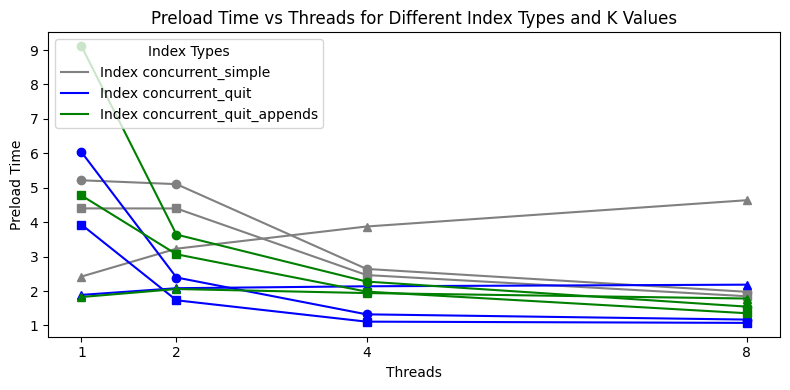

In [64]:
index_types = preload_df["index_type"].unique().to_list()
k_values = sorted(preload_df["K"].unique().to_list())
thread_values = sorted(preload_df["threads"].unique().to_list())

colors = {"concurrent_simple": "grey", "concurrent_quit": "blue", "concurrent_quit_appends": "green"}
markers = {k: ['o', 's', '^'][i % 3] for i, k in enumerate(k_values)}

plt.figure(figsize=(8, 4))

for index in index_types:
    # Filter DataFrame by the current index type
    index_df = preload_df.filter(pl.col("index_type") == index).sort(["K", "threads"])
    # Iterate through each K value
    for k in k_values:
        # Filter DataFrame by the current K value
        k_df = index_df.filter(pl.col("K") == k).sort("threads")
        # Plot preload time against threads for this specific index type and K
        plt.plot(k_df["threads"], k_df["throughput"],
                 label=f'K={k}',
                 color=colors[index],
                 marker=markers[k],
                 linestyle='-')

# Set x-axis ticks and label
plt.xticks(thread_values)
plt.xlabel("Threads")
# Set y-axis label
plt.ylabel("Preload Time")
# Set plot title
plt.title("Preload Time vs Threads for Different Index Types and K Values")
# Add legend
# plt.legend()
# Add a separate legend for Index Types using proxy artists
# Create the legend for K values
legend_k_handles = [plt.plot([], [], marker=markers[k], linestyle='-', color='gray', label=f'K={k}')[0] for k in k_values]
plt.legend(handles=legend_k_handles, title='K Values', loc='upper right')

# Create a separate legend for Index Types using proxy artists
legend_index_handles = [plt.plot([], [], color=colors[index], label=f'Index {index}')[0] for index in index_types]
plt.legend(handles=legend_index_handles, title='Index Types', loc='upper left')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()
# Show the plot
plt.show()

In [20]:
# fetch index types
index_types = df["index_type"].unique().to_list()

# filter and group dfs by index types
grouped_dfs = {}
for index in index_types:
    filtered_df = preload_df.filter(pl.col("index_type") == index).sort("K")
    grouped_dfs[index] = filtered_df

k_values = sorted(preload_df["K"].unique().to_list())

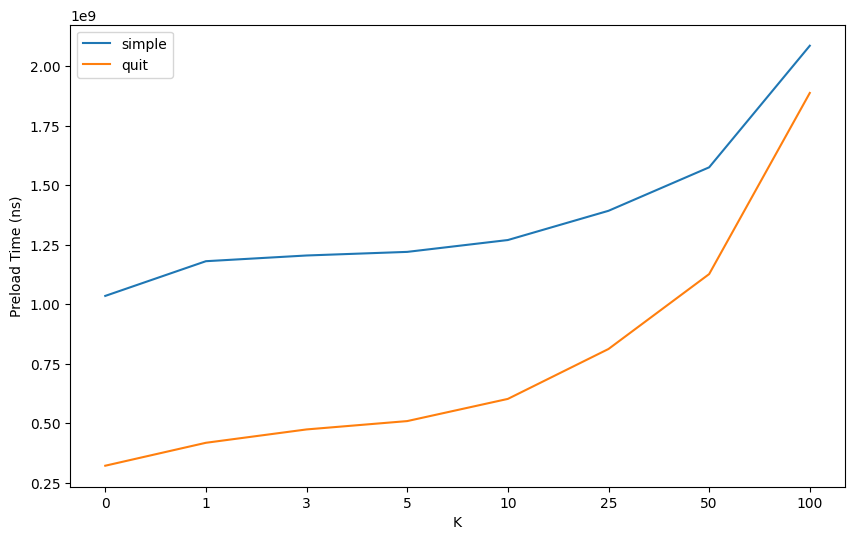

In [21]:
x_positions = np.arange(len(k_values))

plt.figure(figsize=(10,6))

for index, index_df in grouped_dfs.items():
    plt.plot(x_positions, index_df["preload_time"], label=index)

plt.xticks(x_positions, k_values)
plt.xlabel("K")
plt.ylabel("Preload Time (ns)")
plt.legend()
plt.show()